# Searching in a transformed space

In the previous notebook we set up boundaries and created a method to sample from within them.
When doing this, we found it useful to replace some parameter values with their logarithm.
In this part of the tutorial we extend this log-transformation approach to the optimisation routine, so that we search in a (partly) log-transformed space.

## Why transform the search space?

Before performing parameter estimation it _can_ be a good idea to perform some kind of transformations on the search space.
For example, some optimisation methods don't perform well on spaces where the error measure varies very rapidly in one direction, but slowly in another.
In these cases it might help to rescale the parameters, e.g. so that they are all restricted to the interval $[0, 1]$.

For the "a-type" parameters in our model, [Beattie et al.](https://doi.org/10.1113/JP275733) found that the prior expectation was that they'd vary over many orders of magnitude.
As a result, it seemed sensible to use a log-transformation on these parameters when searching, which led to notably improved results.
Experimental confirmation of this approach was provided in the supplemental results to ["Four Ways to Fit an Ion Channel Model"](https://doi.org/10.1016/j.bpj.2019.08.001), section S2.4.2.

While there is no catch-all strategy that we know of, it may be a good idea to try several transformations when dealing with a difficult parameter estimation problem.
The following section will show how.

## Implementing transformations in PINTS

In this section, we'll set up a synthetic data problem with a forward model and boundaries, and then use PINTS to perform the log transformations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import myokit
import pints

In [2]:
# Transformations for the alpha-parameters in the Beattie et al. model.

# No transformation: [x] -> [x]
transform_i = pints.IdentityTransformation
# Log-transformation: [x] -> [log(x)]
transform_l = pints.LogTransformation

transform = pints.ComposedTransformation(
    transform_l(n_parameters=1),  # p1 (alpha)
    transform_i(n_parameters=1),  # p2 (beta)
    transform_l(n_parameters=1),  # p3 (alpha)
    transform_i(n_parameters=1),  # p4 (beta)
    transform_l(n_parameters=1),  # p5 (alpha)
    transform_i(n_parameters=1),  # p6 (beta)
    transform_l(n_parameters=1),  # p7 (alpha)
    transform_i(n_parameters=1),  # p8 (beta)
    transform_i(n_parameters=1),  # maximum conductance
)

Next, we set up an optimisation problem:

In [3]:
# Load a protocol and create a foward model instance
from library import ModelHHSolver as Model
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')
model = Model(protocol)

# Define a parameter vector
parameters = np.array([3e-4, 0.07, 3e-5, 0.05, 0.09, 9e-2, 5e-3, 0.03, 0.2])

# Set up a synthetic data problem and error
times = np.arange(0, 15400, 0.1)
values = model.simulate(parameters, times)
values += np.random.normal(0, 0.025, times.shape)
problem = pints.SingleOutputProblem(model, times, values)
error = pints.MeanSquaredError(problem)

# Create boundaries and take a random sample as initial starting point
from library import Boundaries
boundaries = Boundaries()

# Make a random guess for the parameters
x0 = boundaries.sample(1)[0]

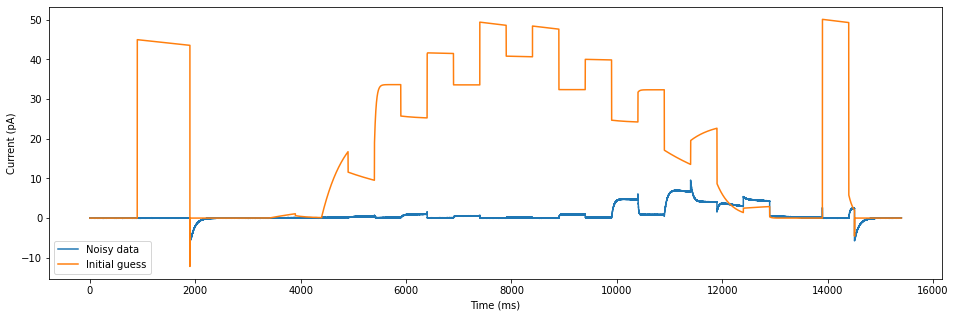

In [4]:
# Visualise the data and starting point
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x0), label='Initial guess')
plt.legend()
plt.show()

Now lets run an optimisation, without using log transforms:

In [5]:
opt = pints.OptimisationController(
    error,
    x0,
    boundaries=boundaries
)
opt.set_parallel(True)
x1, f1 = opt.run()

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 10
Iter. Eval. Best      Time m:s
0     10     641.3762   0:00.1
1     20     626.6075   0:00.2
2     30     576.4783   0:00.3
3     40     545.3991   0:00.3
20    168    112.3865   0:01.2
40    318    23.09349   0:02.1
60    462    11.9793    0:02.9
80    622    5.912512   0:03.8
100   779    4.517934   0:04.7
120   928    4.079749   0:05.7
140   1038   4.072015   0:07.0
160   1167   4.066294   0:07.9
180   1317   3.924393   0:09.0
200   1440   3.752598   0:10.0
220   1577   2.381141   0:10.9
240   1733   1.607682   0:11.8
260   1896   1.607682   0:13.0
280   2085   1.567897   0:14.3
300   2278   1.255868   0:15.8
320   2470   1.031685   0:17.4
340   2662   0.551      0:19.0
360   2810   0.229      0:20.0
380   2964   0.185      0:21.0
400   3139   0.156      0:22.1
420   3318   0.151      0:23.1
440   3507   0.147      0:24.3
460   3700

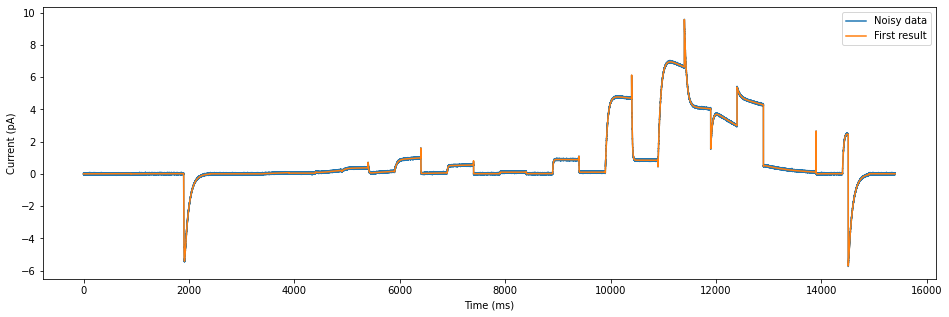

In [6]:
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x1), label='First result')
plt.legend()
plt.show()

And repeat, but this time using log-transforms on the a-type parameters:

In [7]:
# Run the optimisation
opt = pints.OptimisationController(
    error,
    x0,
    boundaries=boundaries,
    transform=transform  # Pass the transformation to the optimiser
)
opt.set_parallel(True)
x2, f2 = opt.run()

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 10
Iter. Eval. Best      Time m:s
0     10     569.1495   0:00.1
1     19     469.0771   0:00.2
2     27     450.9713   0:00.3
3     32     436.9284   0:00.3
20    160    5.404217   0:01.1
40    292    3.779867   0:02.1
60    410    3.740335   0:03.0
80    551    3.733963   0:03.9
100   680    3.73123    0:04.9
120   814    3.727498   0:05.9
140   956    3.716845   0:06.9
160   1091   3.681963   0:07.8
180   1231   3.633747   0:08.8
200   1396   3.458767   0:09.9
220   1524   3.441678   0:10.8
240   1663   3.439554   0:11.9
260   1791   3.436866   0:13.0
280   1914   3.43655    0:14.0
300   2062   3.436075   0:15.0
320   2205   3.434276   0:16.1
340   2344   3.416187   0:17.2
360   2499   3.370277   0:18.4
380   2654   3.19098    0:19.6
400   2786   2.961862   0:20.5
420   2927   2.141563   0:21.5
440   3058   1.756723   0:22.5
460   3195

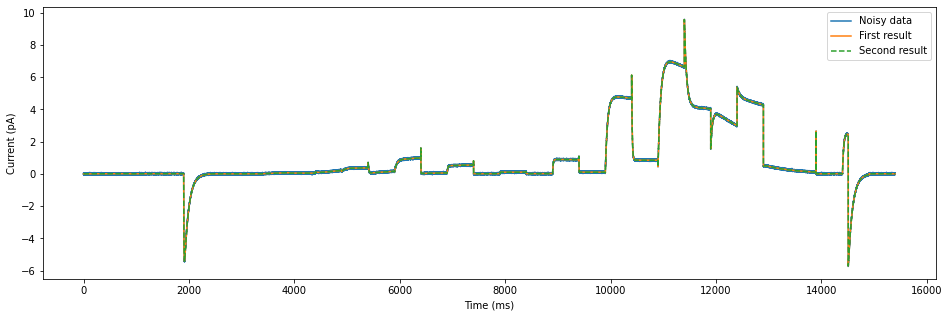

In [8]:
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x1), label='First result')
plt.plot(times, problem.evaluate(x2), '--', label='Second result')
plt.legend()
plt.show()

While there's a fair amount of stochasticity involved in every re-run, there is a good chance that the results above show the same result obtained by both optimisations, but faster (and with a lower number of total evaluations) when using the log transforms.

## Summary

In this part of the tutorial we have

- Created an object that can transform between model and search space
- Created wrappers around a [pints.ForwardModel](https://pints.readthedocs.io/en/latest/core_classes_and_methods.html#pints.ForwardModel) and [pints.Boundaries](https://pints.readthedocs.io/en/latest/boundaries.html#pints.Boundaries) object.
- Used these to run an optimisation in a transformed parameter space.

Some of the classes we've created here will be useful in further parts of the tutorial, so we've stored them in the file [library.py](library.py).

In the next part of the tutorial, we 